Columns loaded: Index(['Id', 'L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8',
       'L0_S0_F10', 'L0_S0_F12', 'L0_S0_F14', 'L0_S0_F16',
       ...
       'L3_S50_F4245', 'L3_S50_F4247', 'L3_S50_F4249', 'L3_S50_F4251',
       'L3_S50_F4253', 'L3_S51_F4256', 'L3_S51_F4258', 'L3_S51_F4260',
       'L3_S51_F4262', 'Response'],
      dtype='object', length=970)
Response label counts:
 Response
0    4968
1      32
Name: count, dtype: int64


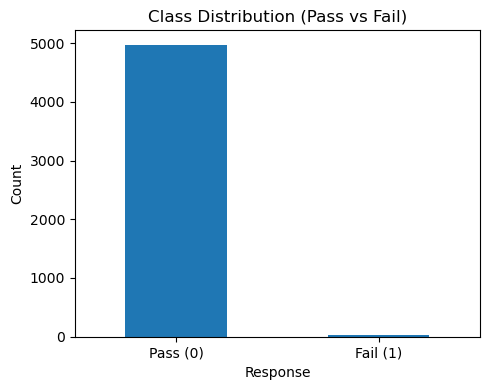

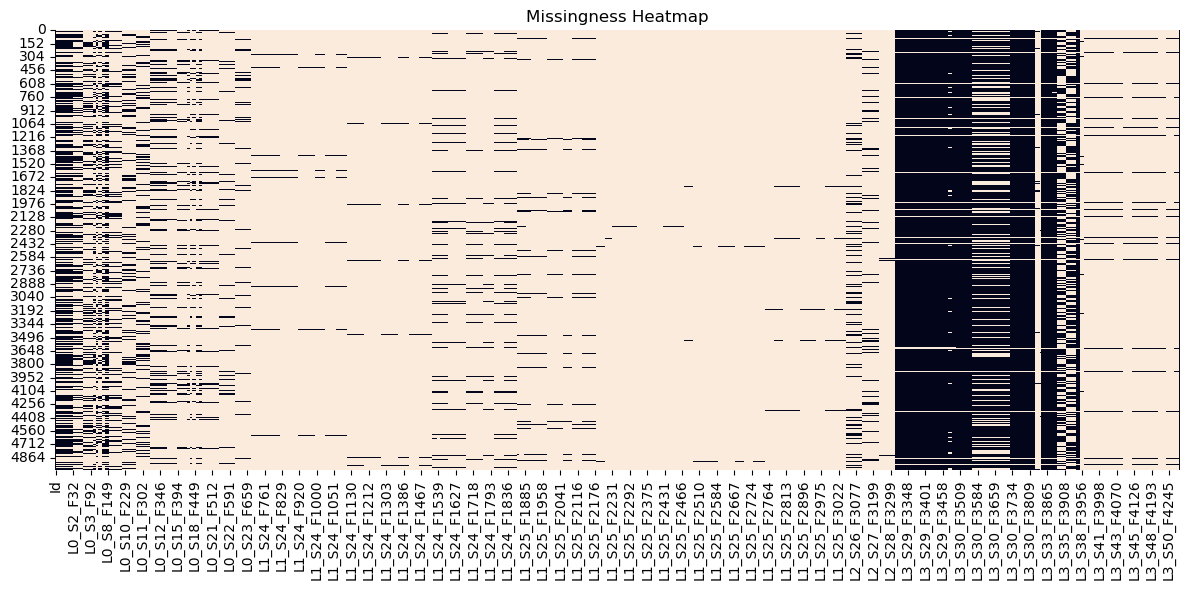

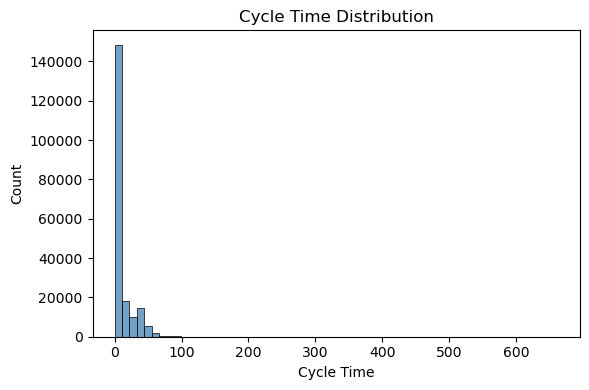

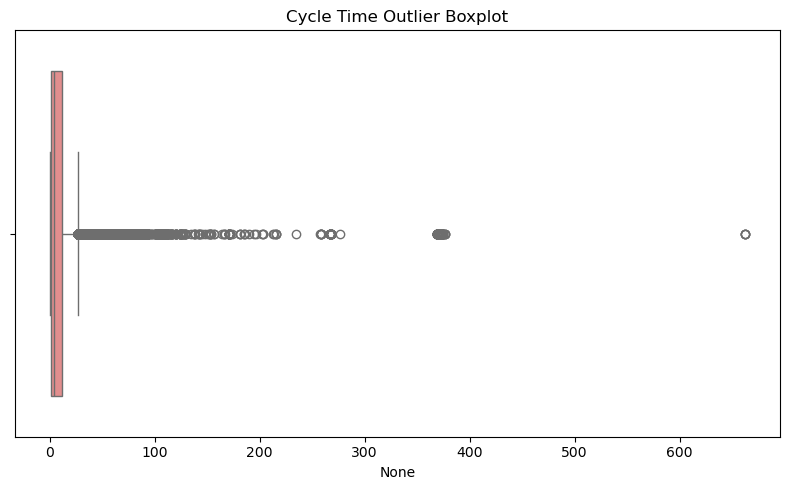

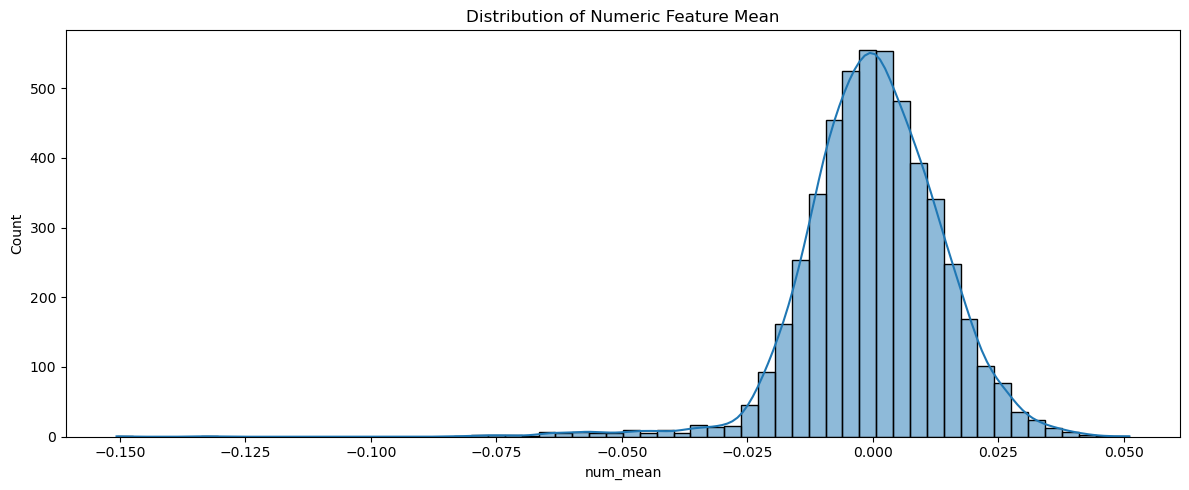

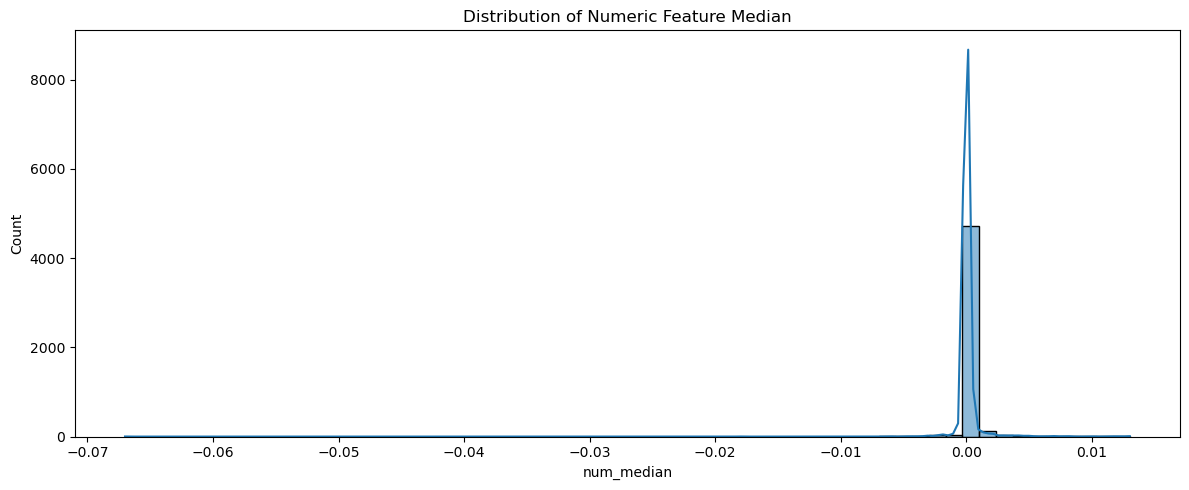

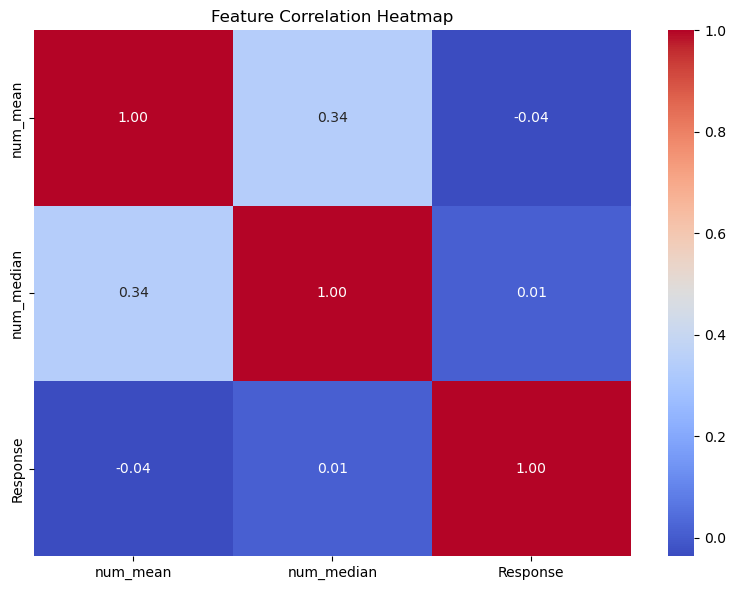

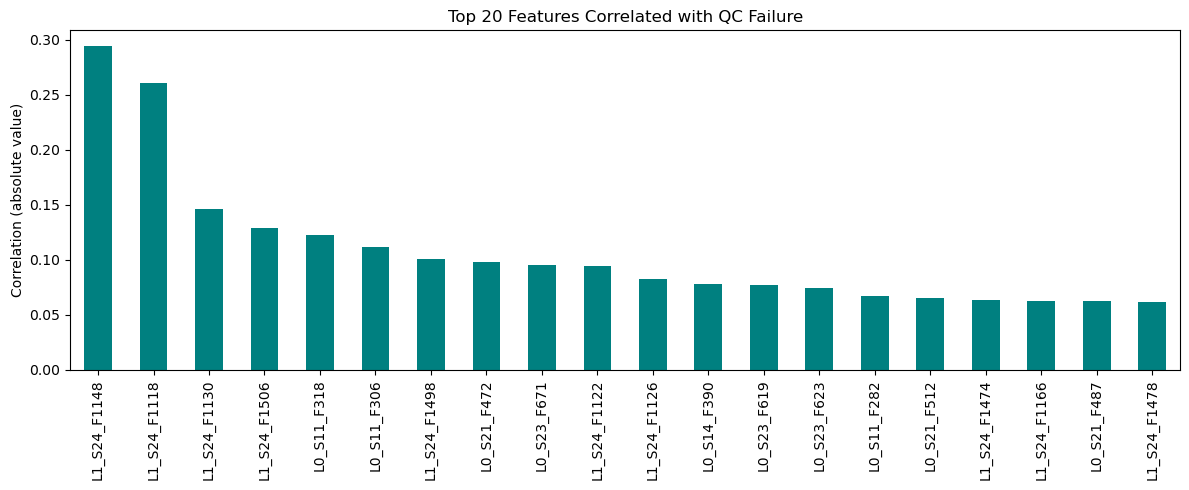

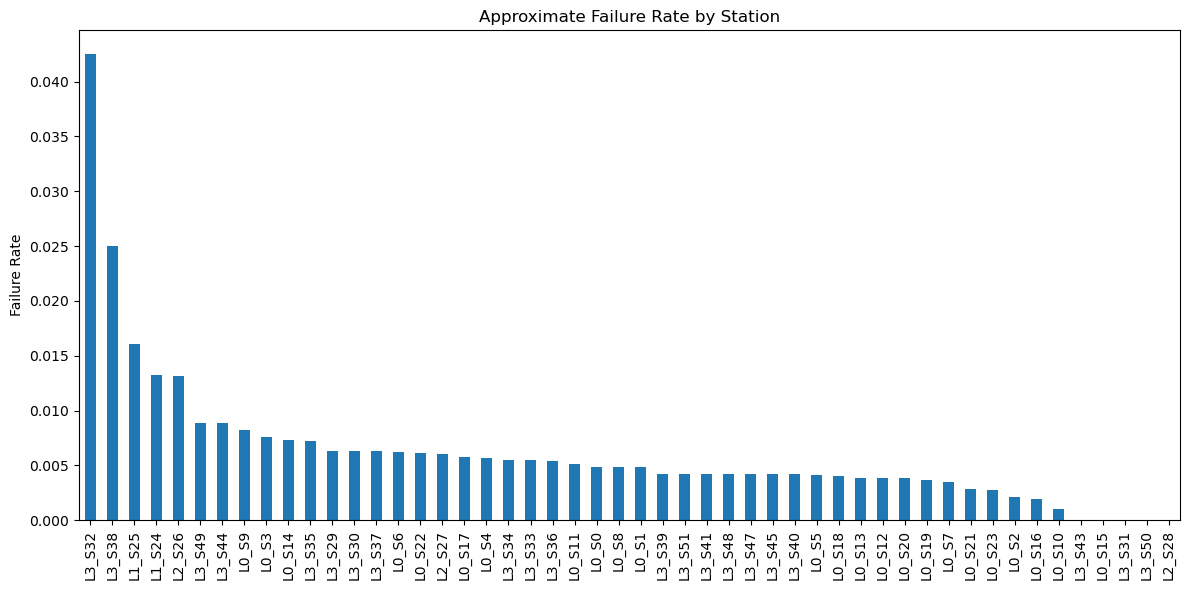

✅ EDA complete with visualizations and KPI report saved.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import re
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ----------------------------
# Settings and paths
# ----------------------------
pd.set_option('display.max_columns', 100)

# Path to raw Bosch data (do not move this)
RAW_DATA_PATH = Path(r"C:\Users\Admin\Downloads\Internship\Bosch_Project_Raw_Data\data\bosch")

# Path to save processed files, figures, and KPIs
PROJECT_DIR = Path(r"C:\Users\Admin\Downloads\Internship\Bosch_PMP")
PROCESSED_DIR = PROJECT_DIR / "data" / "processed"
FIG_DIR = PROJECT_DIR / "reports" / "figures"
KPI_FILE = PROJECT_DIR / "reports" / "kpis.xlsx"

# Make directories if they do not exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
KPI_FILE.parent.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Memory optimization function
# ----------------------------
def downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64', 'int32']).columns:
        df[col] = pd.to_numeric(df[col], downcast='unsigned')
    return df

# ----------------------------
# Station extraction function
# ----------------------------
def extract_station(col):
    m = re.match(r"L(\d+)_S(\d+)_.*", col)
    if m:
        return f"L{m.group(1)}_S{m.group(2)}"
    return None

# ----------------------------
# Load sample numeric and date data
# ----------------------------
numeric_sample = pd.read_csv(RAW_DATA_PATH / "train_numeric.csv.zip", compression='zip', nrows=5000)
numeric_sample = downcast_numeric(numeric_sample)

print("Columns loaded:", numeric_sample.columns)
print("Response label counts:\n", numeric_sample['Response'].value_counts())

date_sample = pd.read_csv(RAW_DATA_PATH / "train_date.csv.zip", compression='zip', nrows=200000)
date_cols = [col for col in date_sample.columns if col != "Id"]
cycle_time = date_sample[date_cols].max(axis=1) - date_sample[date_cols].min(axis=1)

# ----------------------------
# 1. Class Distribution Plot
# ----------------------------
plt.figure(figsize=(5, 4))
numeric_sample['Response'].value_counts().sort_index().plot(kind='bar')
plt.title("Class Distribution (Pass vs Fail)")
plt.xticks([0, 1], ["Pass (0)", "Fail (1)"], rotation=0)
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "class_distribution.png")
plt.show()

# ----------------------------
# 2. Missingness Heatmap
# ----------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_sample.isna(), cbar=False)
plt.title("Missingness Heatmap")
plt.tight_layout()
plt.savefig(FIG_DIR / "missingness_heatmap.png")
plt.show()

# ----------------------------
# 3. Cycle Time Distribution & Boxplot
# ----------------------------
plt.figure(figsize=(6, 4))
sns.histplot(cycle_time.dropna(), bins=60, kde=False, color="steelblue")
plt.title("Cycle Time Distribution")
plt.xlabel("Cycle Time")
plt.tight_layout()
plt.savefig(FIG_DIR / "cycle_time_distribution.png")
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x=cycle_time, color="lightcoral")
plt.title("Cycle Time Outlier Boxplot")
plt.tight_layout()
plt.savefig(FIG_DIR / "cycle_time_boxplot.png")
plt.show()

# ----------------------------
# 4. Numeric feature mean and median
# ----------------------------
mean_series = numeric_sample.drop(columns=["Id", "Response"]).mean(axis=1, skipna=True)
median_series = numeric_sample.drop(columns=["Id", "Response"]).median(axis=1, skipna=True)
numeric_sample = pd.concat([numeric_sample, mean_series.rename("num_mean"), median_series.rename("num_median")], axis=1)

plt.figure(figsize=(12, 5))
sns.histplot(numeric_sample["num_mean"].dropna(), bins=60, kde=True)
plt.title("Distribution of Numeric Feature Mean")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_mean_distribution.png")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(numeric_sample["num_median"].dropna(), bins=60, kde=True)
plt.title("Distribution of Numeric Feature Median")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_median_distribution.png")
plt.show()

# ----------------------------
# 5. Correlation Analysis
# ----------------------------
features_df = numeric_sample[["num_mean", "num_median", "Response"]].copy()
features_df = features_df.loc[:, features_df.nunique(dropna=True) > 1]

plt.figure(figsize=(8, 6))
sns.heatmap(features_df.corr(min_periods=1), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig(FIG_DIR / "correlation_heatmap.png")
plt.show()

# ----------------------------
# 6. Top correlated individual features with Response
# ----------------------------
corrs = {}
num_cols = [c for c in numeric_sample.columns if c not in ["Id", "Response", "num_mean", "num_median"]]
num_cols = [c for c in num_cols if numeric_sample[c].notna().sum() > 100]

for col in num_cols[:200]:
    if numeric_sample[col].nunique(dropna=True) > 1:
        corrs[col] = numeric_sample[col].corr(numeric_sample["Response"])

top_corrs = pd.Series(corrs).dropna().abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 5))
top_corrs.plot(kind="bar", color="teal")
plt.title("Top 20 Features Correlated with QC Failure")
plt.ylabel("Correlation (absolute value)")
plt.tight_layout()
plt.savefig(FIG_DIR / "top_corr_features.png")
plt.show()

# ----------------------------
# 7. Station-wise Failure Rate
# ----------------------------
station_map = {col: extract_station(col) for col in numeric_sample.columns if col not in ['Id', 'Response']}
station_columns = defaultdict(list)
for col, station in station_map.items():
    if station:
        station_columns[station].append(col)

station_failure_rates = {}
for station, cols in station_columns.items():
    mask = numeric_sample[cols].notnull().any(axis=1)
    if mask.sum() > 0:
        failure_rate = numeric_sample.loc[mask, 'Response'].mean()
        station_failure_rates[station] = failure_rate

sfr_series = pd.Series(station_failure_rates).dropna().astype(float).sort_values(ascending=False)

if not sfr_series.empty:
    plt.figure(figsize=(12, 6))
    sfr_series.plot(kind='bar')
    plt.title("Approximate Failure Rate by Station")
    plt.ylabel("Failure Rate")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "station_failure_rate.png")
    plt.show()
    sfr_series.to_csv(PROJECT_DIR / "reports" / "station_failure_rates.csv")

# ----------------------------
# 8. Save KPI summaries to Excel
# ----------------------------
with pd.ExcelWriter(KPI_FILE, engine="xlsxwriter") as writer:
    class_balance = numeric_sample['Response'].value_counts().rename({0: "Pass", 1: "Fail"}).to_frame("Count")
    class_balance["Percent"] = (class_balance["Count"] / class_balance["Count"].sum()).round(4)
    class_balance.to_excel(writer, sheet_name="class_balance")

    cycle_summary = pd.DataFrame({
        "count": [cycle_time.notna().sum()],
        "mean": [cycle_time.mean()],
        "median": [cycle_time.median()],
        "p95": [cycle_time.quantile(0.95)],
        "max": [cycle_time.max()]
    })
    cycle_summary.to_excel(writer, sheet_name="cycle_time_summary", index=False)

print("✅ EDA complete with visualizations and KPI report saved.")
